<a href="https://colab.research.google.com/github/vektor8891/llm/blob/main/projects/21_reward_modeling/21_reward_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install datasets==3.2.0
# !pip install transformers==4.43.4
# !pip install peft==0.14.0
# !pip install trl==0.11

# Reward Modeling

## Defining helper functions

In [2]:
import json

def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

## Data set

In [3]:
from datasets import load_dataset

# Load the Dahoas/synthetic-instruct-gptj-pairwise dataset
dataset = load_dataset("Dahoas/synthetic-instruct-gptj-pairwise")
# Display the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 33143
    })
})


In [4]:
for i in range(10):
    print('prompt')
    print(dataset["train"][i]['prompt'],'\n')

    print('chosen')
    print(dataset[ 'train'][i]['chosen'],'\n')

    print('rejected')
    print(dataset[ 'train'][i]['rejected'],'\n')
    print('---------------------------\n')

prompt
I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs. 

chosen
Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients. 

rejected
How do I store a

## Model and tokenizer setup

In [5]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# Define the model name or path
model_name_or_path = "gpt2"

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path, use_fast=True)
model = GPT2ForSequenceClassification.from_pretrained(model_name_or_path, num_labels=1)

# Add special tokens if necessary
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Define the maximum length
max_length = 1024

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
get_res=lambda dataset,res:[  "\n\nHuman: "+prompt + "\n\nAssistant: "+resp for prompt, resp in zip(dataset["train"]["prompt"], dataset["train"][res])]

In [7]:
chosen_samples=get_res( dataset,'chosen')
rejected_samples=get_res( dataset,'rejected')
print('chosen',chosen_samples[0])
print('rejected',rejected_samples[0])

chosen 

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
rejected 

Huma

In [8]:
# Define a function to combine 'prompt' with 'chosen' and 'rejected' responses
def add_combined_columns(example):
    # Combine 'prompt' with 'chosen' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_chosen'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["chosen"]

    # Combine 'prompt' with 'rejected' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_rejected'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["rejected"]

    # Return the modified example
    return example

# Apply the function to each example in the 'train' split of the dataset
dataset['train'] = dataset['train'].map(add_combined_columns)

In [9]:
get_max_len= lambda samples: max([len(sample) for sample in samples])
get_max_len

<function __main__.<lambda>(samples)>

In [10]:
print("rejected samples length",get_max_len(rejected_samples))
print("chosen samples length",get_max_len(chosen_samples))

rejected samples length 5011
chosen samples length 3167


In [11]:
find_short = lambda dataset, max_length: [
    i for i, (chosen, rejected) in enumerate(zip(dataset['prompt_chosen'], dataset['prompt_rejected']))
    if len(chosen) < max_length or len(rejected) < max_length
]

In [12]:
max_length=1024
subset_indices=find_short (dataset['train'], max_length)
dataset['train'] = dataset['train'].select(subset_indices)
subset_indices[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
# Define a preprocessing function to tokenize the 'prompt_chosen' and 'prompt_rejected' keys
def preprocess_function(examples):
    # Tokenize the 'prompt_chosen' text with truncation and padding to the maximum length
    tokenized_chosen = tokenizer(examples['prompt_chosen'], truncation=True, max_length=max_length, padding="max_length")

    # Tokenize the 'prompt_rejected' text with truncation and padding to the maximum length
    tokenized_rejected = tokenizer(examples['prompt_rejected'], truncation=True, max_length=max_length, padding="max_length")

    # Return the tokenized inputs as a dictionary
    return {
        "input_ids_chosen": tokenized_chosen["input_ids"],  # Token IDs for 'chosen' responses
        "attention_mask_chosen": tokenized_chosen["attention_mask"],  # Attention masks for 'chosen' responses
        "input_ids_rejected": tokenized_rejected["input_ids"],  # Token IDs for 'rejected' responses
        "attention_mask_rejected": tokenized_rejected["attention_mask"],  # Attention masks for 'rejected' responses
    }

In [14]:
example=preprocess_function(dataset['train'][0])
example.keys()

dict_keys(['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'])

In [15]:
train_str={'chosen': [sample for sample in dataset['train'] ['prompt_chosen']], 'rejected':[sample for sample in dataset['train'] ['prompt_rejected']]}

In [16]:
dataset['train'] = dataset['train'].map(preprocess_function, batched=True, remove_columns=['prompt',"chosen", "rejected",'prompt_chosen', 'prompt_rejected'])

In [17]:
dataset.column_names

{'train': ['input_ids_chosen',
  'attention_mask_chosen',
  'input_ids_rejected',
  'attention_mask_rejected']}

In [18]:
from datasets import DatasetDict

split_dataset = dataset['train'].train_test_split(test_size=0.2)

# Create a DatasetDict to hold train and test splits
dataset_dict = DatasetDict({
    'train': split_dataset['train'],
    'test': split_dataset['test'],
})

## LoRA configuration

In [19]:
from peft import LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["attn.c_attn", "attn.c_proj"]  # Target attention layers
)

## Training arguments

In [20]:
from transformers import TrainingArguments

# Define training arguments

training_args = TrainingArguments(
    per_device_train_batch_size=3,  # Set to 3
    num_train_epochs=3,  # Set to 3
    gradient_accumulation_steps=8,
    learning_rate=1.41e-5,
    output_dir="./model_output3",
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
)

### RewardTrainer


In [21]:
from trl import RewardTrainer

# Initialize RewardTrainer
trainer = RewardTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['test'],
    peft_config=peft_config,
)

/usr/local/lib/python3.11/dist-packages/trl/trainer/reward_trainer.py:120: FutureWarning: Using `transformers.TrainingArguments` for `args` is deprecated and will be removed in a future version. Please use `RewardConfig` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/reward_trainer.py:174: UserWarning: When using RewardDataCollatorWithPadding, you should set `max_length` in RewardConfig. It will be set to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/reward_trainer.py:199: UserWarning: When using RewardDataCollatorWithPadding, you should set `remove_unused_columns=False` in your RewardConfig we have set it for you, but you should do it yourself in the future.
  warnings.warn

In [22]:
# output_dir="./model_output3"

# # Train the model
# trainer.train()

# # Save the model
# trainer.save_model(output_dir)

# # Evaluate the model
# metrics = trainer.evaluate()
# print(metrics)

# model.config.save_pretrained("./backup")

In [23]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VZcK8FJ-kQ3nEJoxWGNYTQ/RetriverTrainerModel.zip

--2025-06-03 15:18:44--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VZcK8FJ-kQ3nEJoxWGNYTQ/RetriverTrainerModel.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13238247 (13M) [application/zip]
Saving to: ‘RetriverTrainerModel.zip.1’

RetriverTrainerMode 100%[===================>]  12.62M  --.-KB/s    in 0.09s   

2025-06-03 15:18:45 (133 MB/s) - ‘RetriverTrainerModel.zip.1’ saved [13238247/13238247]



In [24]:
!unzip -o RetriverTrainerModel.zip -d extracted_model

Archive:  RetriverTrainerModel.zip
  inflating: extracted_model/__MACOSX/._model_output3  
  inflating: extracted_model/__MACOSX/model_output3/._checkpoint-2500  
  inflating: extracted_model/model_output3/adapter_model.safetensors  
  inflating: extracted_model/__MACOSX/model_output3/._adapter_model.safetensors  
  inflating: extracted_model/model_output3/.DS_Store  
  inflating: extracted_model/__MACOSX/model_output3/._.DS_Store  
  inflating: extracted_model/model_output3/tokenizer_config.json  
  inflating: extracted_model/__MACOSX/model_output3/._tokenizer_config.json  
  inflating: extracted_model/model_output3/special_tokens_map.json  
  inflating: extracted_model/__MACOSX/model_output3/._special_tokens_map.json  
  inflating: extracted_model/model_output3/config.json  
  inflating: extracted_model/__MACOSX/model_output3/._config.json  
  inflating: extracted_model/model_output3/README.md  
  inflating: extracted_model/__MACOSX/model_output3/._README.md  
  inflating: extracted_

## Evaluating the model

In [25]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = GPT2ForSequenceClassification.from_pretrained("./extracted_model/model_output3", num_labels=1).to(DEVICE)
model

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): lora.Linear(
            (base_layer): Conv1D()
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (c_proj): lora.Linear(
            (base_layer): Conv1D()
            (lora_dropou

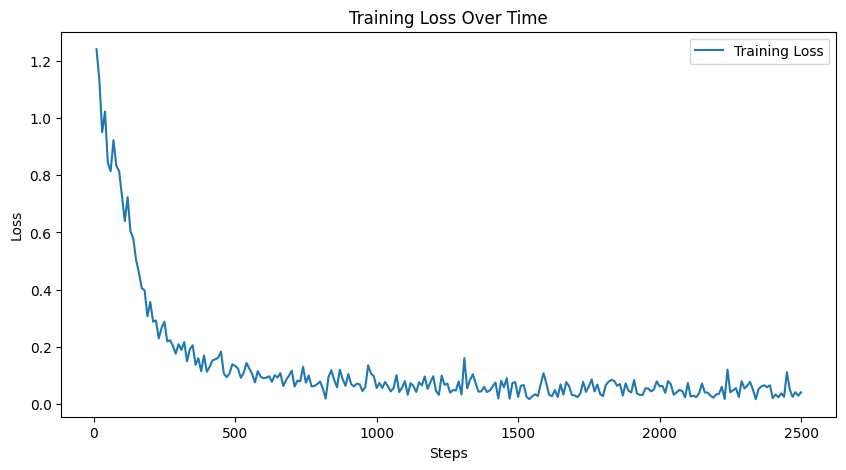

In [26]:
import matplotlib.pyplot as plt

log_file = f"extracted_model/model_output3/checkpoint-2500/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# Extract training loss values
steps = []
losses = []
for log in logs["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

In [27]:
text1=train_str['chosen'][0]
print(text1)



Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.


In [28]:
inputs = tokenizer(text1, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move inputs to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logit_1 = outputs.logits
print("Score :",logit_1 )

Score : tensor([[7.6648]])


In [29]:
text2=train_str['rejected'][0]
print(text2)



Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: How do I store a bagels for eating at a later date?


 You can place the bagels in an airtight container and reheat them in the microwave.  Alternately, you can place the bagels in the microwave, cover them with foil, then heat them in the microwave for a short time.


In [30]:
inputs = tokenizer(text2, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move inputs to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logit_2 = outputs.logits
print("Score :",logit_2 )

Score : tensor([[-7.6373]])


In [31]:
if logit_1 > logit_2:
    print("--------selected---------")
    print(text1, logit_1.detach().item())
    print("--------rejected---------")
    print(text2, logit_2.detach().item())
else:
    print("selected ")
    print(text2, logit_2.detach().item())
    print("rejected")
    print(text2, logit_2.detach().item())

--------selected---------


Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrien

In [32]:
# Function to make a prediction and get the logits
def predict_and_get_logits(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform the forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the logits from the outputs
    logits = outputs.logits.squeeze().item()  # Assuming binary classification and batch size of 1

    return logits

In [33]:
# Function to compare two texts
def compare_texts(text1, text2):
    logit1 = predict_and_get_logits(text1)
    logit2 = predict_and_get_logits(text2)

    if logit1 > logit2:
        print("selected---------")
        print(text1, f"score: {logit1}")

        return text1
    else:
        print("selected---------")
        print(text2,  f"score: {logit2}")

        return text2

In [34]:
# Define the number of samples to evaluate
N = 10

# Initialize a counter for correct selections
correct_selections = 0

# Iterate over the first N pairs of chosen and rejected responses
for chosen, rejected in zip(train_str['chosen'][0:N], train_str['rejected'][0:N]):
    # Print the chosen response for reference
    print("Chosen Response:\n", chosen)

    # Use the compare_texts function to determine which response is better
    selected_text = compare_texts(chosen, rejected)

    # Check if the selected text is the chosen response
    if selected_text == chosen:
        correct_selections += 1

# Calculate the accuracy as the ratio of correct selections to the total number of samples
accuracy = correct_selections / N

# Print the accuracy
print("Accuracy:", accuracy)

Chosen Response:
 

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
sele

## Exercise: Evaluate model's preference accuracy on a different subset of data

In [35]:
# Define the number of samples to evaluate from a different subset
K = 50

# Initialize a counter for correct selections
correct_selections = 0

# Determine the starting index for the different subset (e.g., middle of the dataset)
start_index = len(train_str['chosen']) // 2

# Iterate over K pairs of chosen and rejected responses from the different subset
for chosen, rejected in zip(train_str['chosen'][start_index:start_index + K], train_str['rejected'][start_index:start_index + K]):
    # Use the compare_texts function to determine which response is better
    selected_text = compare_texts(chosen, rejected)

    # Check if the selected text is the chosen response
    if selected_text == chosen:
        correct_selections += 1

# Calculate the accuracy as the ratio of correct selections to the total number of samples
accuracy = correct_selections / K

# Print the accuracy
print("Accuracy on different subset:", accuracy)

selected---------


Human: What's the best way to store old wines.

Assistant: The best way to store old wines is in a cool, dark place, away from direct sunlight and with temperatures that stay consistent. It is important to also ensure that the humidity levels are reasonably high, as this helps keep the cork moist. Finally, wine should always be stored on its side to keep the cork wet and prevent air from entering the bottle. score: 7.429327487945557
selected---------


Human: What kids activities can I do that link to geography.

Assistant: One activity you can do with kids that link to geography is to make a map. Have them draw a map of their local area or even the world. They can use a variety of resources like books, online maps, and even globe ornaments. Talk about the features: rivers, mountains, cities, parks, and more. Give them a homework assignment to learn about some geographic area and then ask them to teach the class about that location. You can also bring in a variety o

In [36]:
!pip freeze > requirements.txt